In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

In [2]:
train_file = 'data/in/train.csv'
test_file = 'data/in/test.csv'

train_data = pd.read_csv(train_file,index_col=0)
test_data = pd.read_csv(test_file,index_col=0)

In [3]:
train_data.head()

,FECHA,LATITUD_ORIGEN,LONGITUD_ORIGEN,LATITUD_DESTINO,LONGITUD_DESTINO,DISTANCIA,TIEMPO
ID,,,,,,,
124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0
124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0
124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0
124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0
124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0


In [4]:
la_orig = train_data['LATITUD_ORIGEN'].values
lo_orig = train_data['LONGITUD_ORIGEN'].values
la_dest = train_data['LATITUD_DESTINO'].values
lo_dest = train_data['LONGITUD_DESTINO'].values

distances = []
for la1, lo1, la2, lo2 in zip(la_orig,lo_orig,la_dest,lo_dest):
    dist = geopy.distance.distance((la1,lo1),(la2,lo2)).m
    distances.append(dist)

train_data['EARTH_DISTANCE'] = distances

In [5]:
train_data.head()

,FECHA,LATITUD_ORIGEN,LONGITUD_ORIGEN,LATITUD_DESTINO,LONGITUD_DESTINO,DISTANCIA,TIEMPO,EARTH_DISTANCE
ID,,,,,,,,
124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,11709.759288
124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,11104.026667
124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,44070.222890
124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,20401.135922
124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,9285.408508


In [6]:
la_orig = test_data['LATITUD_ORIGEN'].values
lo_orig = test_data['LONGITUD_ORIGEN'].values
la_dest = test_data['LATITUD_DESTINO'].values
lo_dest = test_data['LONGITUD_DESTINO'].values

distances = []
for la1, lo1, la2, lo2 in zip(la_orig,lo_orig,la_dest,lo_dest):
    dist = geopy.distance.distance((la1,lo1),(la2,lo2)).m
    distances.append(dist)

test_data['EARTH_DISTANCE'] = distances

In [7]:
test_data.head()

,FECHA,LATITUD_ORIGEN,LONGITUD_ORIGEN,LATITUD_DESTINO,LONGITUD_DESTINO,EARTH_DISTANCE
ID,,,,,,
124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,37618.751360
124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,68841.223973
124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,9532.156469
124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,10185.051111
124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,8633.569104


In [8]:
X=train_data.iloc[:,[False,True,True,True,True,False,False,True]].values
y=train_data.iloc[:,5:-1].values
yhat=test_data.iloc[:,1:].values

In [9]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, 0.54753148, 0.03653944],
       [0.74842017, 0.22806174, 0.72358461, 0.26564229, 0.06726531],
       [0.4134065 , 0.34430488, 0.41945535, 0.35188306, 0.00889957],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, 0.34470825, 0.01789533],
       [0.40340026, 0.3552709 , 0.42098601, 0.39107818, 0.04980804],
       [0.15010318, 0.93230005, 0.23882396, 0.90311374, 0.13651709]])

In [10]:
from keras.optimizers import Adam

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer=Adam(learning_rate=0.5e-3))
    return model

In [11]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
print(X.shape[1], y.shape[1])

5 2


In [12]:
from keras.callbacks import ModelCheckpoint

def get_callbacks():
    filepath = 'data/out/try3.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try3.csv')
    
    return [callback1,callback2]

In [13]:
model = get_model(n_inputs, n_outputs)
history = model.fit(X, y, verbose=1, epochs=300, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/300
50/50 [==============================] - 1s 23ms/step - loss: 415.0371 - val_loss: 379.9841

Epoch 00001: loss improved from inf to 405.25674, saving model to data/out\try3.h5
Epoch 2/300
50/50 [==============================] - 0s 2ms/step - loss: 359.1948 - val_loss: 315.0387

Epoch 00002: loss improved from 405.25674 to 341.11197, saving model to data/out\try3.h5
Epoch 3/300
50/50 [==============================] - 0s 2ms/step - loss: 294.2919 - val_loss: 251.4374

Epoch 00003: loss improved from 341.11197 to 278.76715, saving model to data/out\try3.h5
Epoch 4/300
50/50 [==============================] - 0s 2ms/step - loss: 232.5545 - val_loss: 187.9893

Epoch 00004: loss improved from 278.76715 to 217.21666, saving model to data/out\try3.h5
Epoch 5/300
50/50 [==============================] - 0s 2ms/step - loss: 170.2400 - val_loss: 124.7925

Epoch 00005: loss improved from 217.21666 to 155.68712, saving model to data/out\try3.h5
Epoch 6/300
50/50 [=====================

50/50 [==============================] - 0s 1ms/step - loss: 20.6256 - val_loss: 21.6270

Epoch 00044: loss improved from 20.89341 to 20.87648, saving model to data/out\try3.h5
Epoch 45/300
50/50 [==============================] - 0s 1ms/step - loss: 20.8348 - val_loss: 21.7629

Epoch 00045: loss improved from 20.87648 to 20.79300, saving model to data/out\try3.h5
Epoch 46/300
50/50 [==============================] - 0s 1ms/step - loss: 20.9150 - val_loss: 21.4636

Epoch 00046: loss improved from 20.79300 to 20.77204, saving model to data/out\try3.h5
Epoch 47/300
50/50 [==============================] - 0s 1ms/step - loss: 20.8981 - val_loss: 21.4214

Epoch 00047: loss improved from 20.77204 to 20.75883, saving model to data/out\try3.h5
Epoch 48/300
50/50 [==============================] - 0s 1ms/step - loss: 20.3369 - val_loss: 21.3649

Epoch 00048: loss improved from 20.75883 to 20.67499, saving model to data/out\try3.h5
Epoch 49/300
50/50 [==============================] - 0s 1ms/st


Epoch 00088: loss did not improve from 19.45001
Epoch 89/300
50/50 [==============================] - 0s 1ms/step - loss: 19.4921 - val_loss: 20.1077

Epoch 00089: loss improved from 19.45001 to 19.38609, saving model to data/out\try3.h5
Epoch 90/300
50/50 [==============================] - 0s 1ms/step - loss: 19.7755 - val_loss: 20.1429

Epoch 00090: loss improved from 19.38609 to 19.34435, saving model to data/out\try3.h5
Epoch 91/300
50/50 [==============================] - 0s 1ms/step - loss: 19.5059 - val_loss: 20.0694

Epoch 00091: loss did not improve from 19.34435
Epoch 92/300
50/50 [==============================] - 0s 1ms/step - loss: 19.1334 - val_loss: 20.1226

Epoch 00092: loss improved from 19.34435 to 19.29908, saving model to data/out\try3.h5
Epoch 93/300
50/50 [==============================] - 0s 1ms/step - loss: 19.5162 - val_loss: 20.0293

Epoch 00093: loss did not improve from 19.29908
Epoch 94/300
50/50 [==============================] - 0s 1ms/step - loss: 19.40

50/50 [==============================] - 0s 1ms/step - loss: 18.5496 - val_loss: 19.7119

Epoch 00139: loss improved from 18.92827 to 18.92767, saving model to data/out\try3.h5
Epoch 140/300
50/50 [==============================] - 0s 1ms/step - loss: 18.8600 - val_loss: 19.6695

Epoch 00140: loss did not improve from 18.92767
Epoch 141/300
50/50 [==============================] - 0s 1ms/step - loss: 19.4168 - val_loss: 19.6554

Epoch 00141: loss did not improve from 18.92767
Epoch 142/300
50/50 [==============================] - 0s 1ms/step - loss: 18.7142 - val_loss: 19.7991

Epoch 00142: loss did not improve from 18.92767
Epoch 143/300
50/50 [==============================] - 0s 1ms/step - loss: 19.2065 - val_loss: 19.7109

Epoch 00143: loss improved from 18.92767 to 18.90416, saving model to data/out\try3.h5
Epoch 144/300
50/50 [==============================] - 0s 1ms/step - loss: 19.3067 - val_loss: 19.6624

Epoch 00144: loss improved from 18.90416 to 18.88554, saving model to da

50/50 [==============================] - 0s 1ms/step - loss: 18.4502 - val_loss: 19.5438

Epoch 00190: loss improved from 18.76207 to 18.74422, saving model to data/out\try3.h5
Epoch 191/300
50/50 [==============================] - 0s 1ms/step - loss: 19.1088 - val_loss: 19.4749

Epoch 00191: loss did not improve from 18.74422
Epoch 192/300
50/50 [==============================] - 0s 1ms/step - loss: 18.8699 - val_loss: 19.4657

Epoch 00192: loss did not improve from 18.74422
Epoch 193/300
50/50 [==============================] - 0s 1ms/step - loss: 18.8771 - val_loss: 19.4591

Epoch 00193: loss did not improve from 18.74422
Epoch 194/300
50/50 [==============================] - 0s 1ms/step - loss: 19.2704 - val_loss: 19.4407

Epoch 00194: loss improved from 18.74422 to 18.74283, saving model to data/out\try3.h5
Epoch 195/300
50/50 [==============================] - 0s 1ms/step - loss: 18.4120 - val_loss: 19.4543

Epoch 00195: loss did not improve from 18.74283
Epoch 196/300
50/50 [===

50/50 [==============================] - 0s 1ms/step - loss: 18.2102 - val_loss: 19.4344

Epoch 00241: loss did not improve from 18.58484
Epoch 242/300
50/50 [==============================] - 0s 1ms/step - loss: 18.6186 - val_loss: 19.5262

Epoch 00242: loss did not improve from 18.58484
Epoch 243/300
50/50 [==============================] - 0s 1ms/step - loss: 19.1092 - val_loss: 19.3420

Epoch 00243: loss did not improve from 18.58484
Epoch 244/300
50/50 [==============================] - 0s 1ms/step - loss: 18.8219 - val_loss: 19.4199

Epoch 00244: loss did not improve from 18.58484
Epoch 245/300
50/50 [==============================] - 0s 1ms/step - loss: 18.9181 - val_loss: 19.3326

Epoch 00245: loss did not improve from 18.58484
Epoch 246/300
50/50 [==============================] - 0s 1ms/step - loss: 18.6193 - val_loss: 19.4499

Epoch 00246: loss did not improve from 18.58484
Epoch 247/300
50/50 [==============================] - 0s 1ms/step - loss: 18.5808 - val_loss: 19.3395

50/50 [==============================] - 0s 1ms/step - loss: 18.5107 - val_loss: 19.3418

Epoch 00294: loss improved from 18.55782 to 18.53989, saving model to data/out\try3.h5
Epoch 295/300
50/50 [==============================] - 0s 1ms/step - loss: 18.3852 - val_loss: 19.3198

Epoch 00295: loss did not improve from 18.53989
Epoch 296/300
50/50 [==============================] - 0s 1ms/step - loss: 18.5185 - val_loss: 19.4130

Epoch 00296: loss did not improve from 18.53989
Epoch 297/300
50/50 [==============================] - 0s 1ms/step - loss: 18.9129 - val_loss: 19.4151

Epoch 00297: loss did not improve from 18.53989
Epoch 298/300
50/50 [==============================] - 0s 1ms/step - loss: 18.8168 - val_loss: 19.3248

Epoch 00298: loss did not improve from 18.53989
Epoch 299/300
50/50 [==============================] - 0s 1ms/step - loss: 18.5732 - val_loss: 19.3269

Epoch 00299: loss did not improve from 18.53989
Epoch 300/300
50/50 [==============================] - 0s 1ms/s

In [14]:
#Cargando el mejor modelo

from keras.models import load_model
best_model_tf = load_model('data/out/try3.h5')

ypred = best_model_tf.predict(yhat)

In [15]:
print(ypred)

[[ 49895.992    3654.753 ]
 [ 91050.984    5751.803 ]
 [ 12799.493    1561.6355]
 ...
 [ 24938.518    2389.698 ]
 [ 67671.31     4585.2017]
 [183760.17    10516.6875]]


In [16]:
best_model_tf.evaluate(X,y)

63/63 [==============================] - 0s 468us/step - loss: 18.7118


18.711774826049805

In [17]:
ids = pd.read_csv(test_file)
ids_1 = ids['ID']

In [18]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   49895.992188   3654.752930
1    124093149   91050.984375   5751.803223
2    124090750   12799.493164   1561.635498
3    124092491   13674.532227   1640.073364
4    124091871   11594.572266   1454.940796
..         ...            ...           ...
847  124088805   13324.270508   1608.062378
848  124089757   11552.258789   1451.167480
849  124089569   24938.517578   2389.697998
850  124092518   67671.312500   4585.201660
851  124090644  183760.171875  10516.687500

[852 rows x 3 columns]


In [19]:
df.to_csv('data/out/try3_out.csv',index=False)

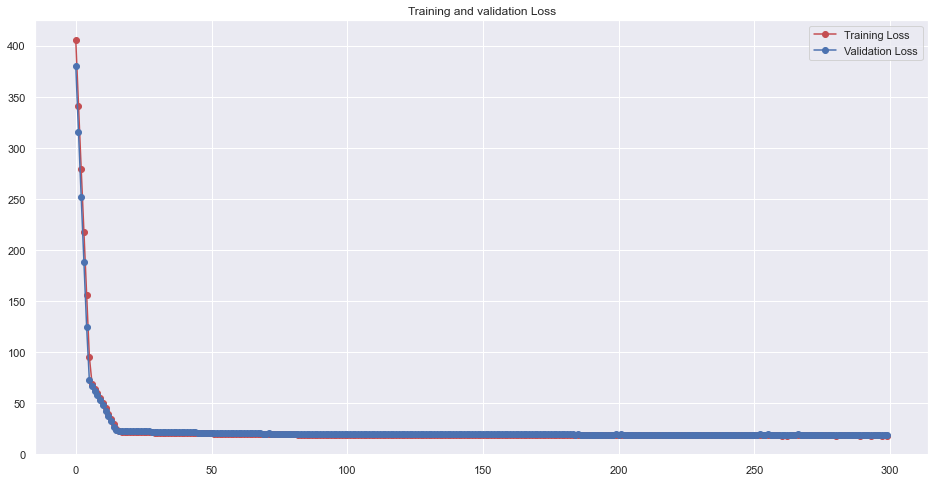

<Figure size 432x288 with 0 Axes>

In [20]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()